# Boxplot of top five up- and downregulated genes

In [1]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Functions

In [2]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## All genes

### Differential expressed genes

In [3]:
genes = read.delim('../../_m/genes/diffExpr_maleVfemale_full.txt')
genes = genes %>% filter(adj.P.Val < 0.05) %>%  
            select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Male Bias') %>% head(5) 
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Female Bias') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}

sig_genes

gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000226555.1,ENSG00000226555,AGKP1,7.2707515,100.74663,1.837492e-256,< 2e-16,****,Male Bias,AGKP1
ENSG00000229236.1,ENSG00000229236,TTTY10,7.4174721,95.66719,3.642704e-249,< 2e-16,****,Male Bias,TTTY10
ENSG00000176728.7,ENSG00000176728,TTTY14,8.8137296,94.58189,1.140965e-247,< 2e-16,****,Male Bias,TTTY14
ENSG00000260197.1,ENSG00000260197,,7.0188875,92.14131,5.725810e-244,< 2e-16,****,Male Bias,ENSG00000260197
ENSG00000241859.6,ENSG00000241859,ANOS2P,7.6377356,87.17840,5.448917e-236,< 2e-16,****,Male Bias,ANOS2P
ENSG00000229807.10,ENSG00000229807,XIST,-10.3458226,-70.10717,3.700997e-205,< 2e-16,****,Female Bias,XIST
ENSG00000005889.15,ENSG00000005889,ZFX,-0.6708320,-40.03090,7.774589e-130,< 2e-16,****,Female Bias,ZFX
ENSG00000126012.11,ENSG00000126012,KDM5C,-0.4649178,-28.47903,2.544071e-90,< 2e-16,****,Female Bias,KDM5C
ENSG00000130021.13,ENSG00000130021,PUDP,-0.5443580,-22.24347,4.161668e-66,< 2e-16,****,Female Bias,PUDP


### Load residualized expression

In [4]:
res_file = '../../_m/genes/residualized_expression.tsv'
tmp_df = data.table::fread(res_file, data.table=F)

resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

Warning message in data.table::fread(res_file, data.table = F):
“Detected 359 column names but the data has 360 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,ENSG00000130021.13,ENSG00000005889.15,ENSG00000215301.9,ENSG00000126012.11,ENSG00000229807.10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R10424,1.1558959,-1.1321828,-0.2438417,-1.4370551,-1.875028
R12195,-0.2108949,-0.8164384,-0.7824775,-0.3988335,-1.065990


### Load pheno data

In [5]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/dlpfc_phenotypes.csv'
pheno <- data.table::fread(pheno_file) %>% 
    mutate_if(is.character, as.factor) %>% 
    column_to_rownames("V1")
levels(pheno$Sex) <- c("Female", "Male")
head(pheno, 2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
R10424,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,Control
R12195,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,Schizo


### Merge dataframe

In [6]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 359  19

,rowname,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,ENSG00000130021.13
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,R10424,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,Control,1.1558959
2,R12195,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,Schizo,-0.2108949


### Melt data frame

In [7]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(sig_genes, by='gencodeID') %>% mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

rowname,Sex,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R10424,Male,ENSG00000130021.13,1.155896,ENSG00000130021,PUDP,-0.544358,-22.24347,4.161668e-66,< 2e-16,****,Female Bias,PUDP
R10424,Male,ENSG00000005889.15,-1.132183,ENSG00000005889,ZFX,-0.670832,-40.03090,7.774589e-130,< 2e-16,****,Female Bias,ZFX


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


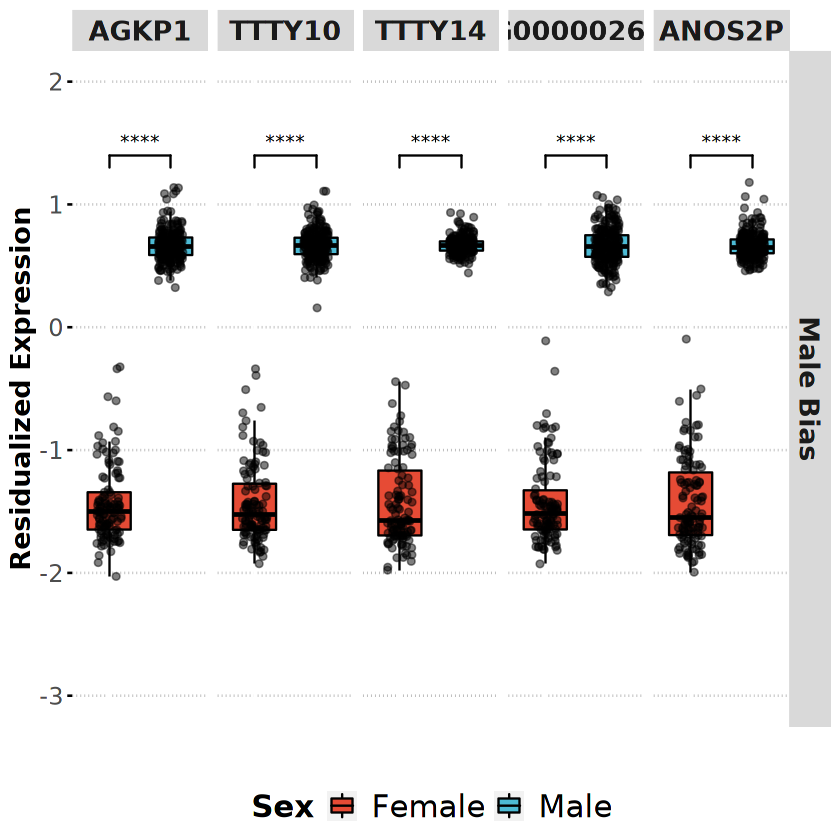

In [8]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=1.4) %>% filter(Direction == 'Male Bias') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Male Bias") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), fill="Sex", xlab='', 
                  panel.labs.font=list(face='bold', size = 16), palette="npg", outlier.shape=NA,
                  ylab='Residualized Expression', add='jitter', ylim=c(-3, 2),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


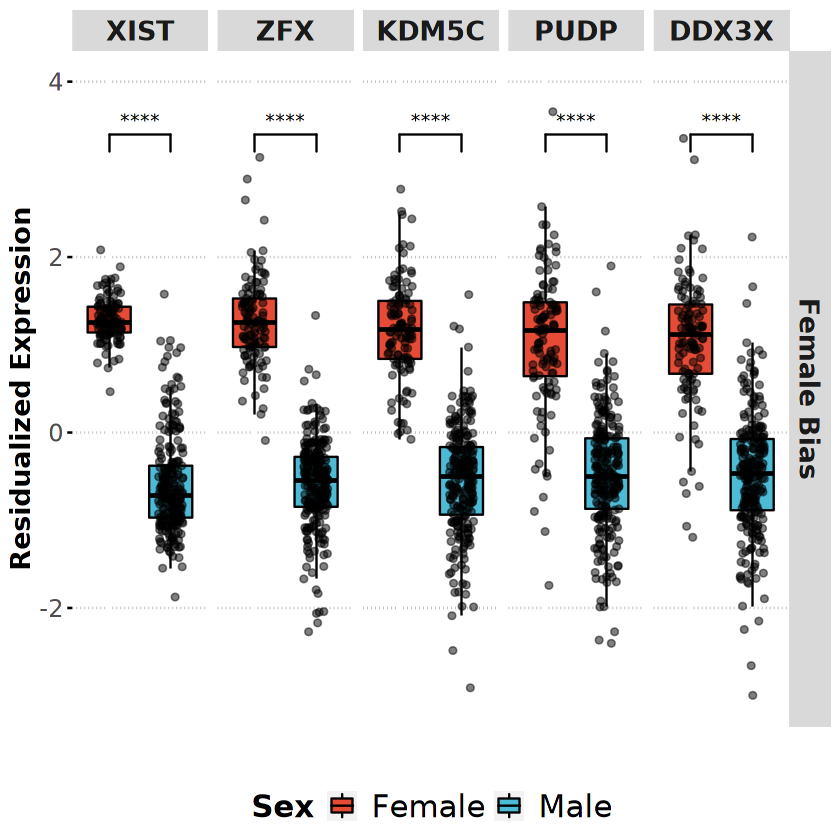

In [9]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=3.4) %>% filter(Direction == 'Female Bias') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=='Female Bias') %>% 
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                  facet.by=c("Direction", "New_ID"), panel.labs.font=list(face='bold', size = 16), 
                  ylab='Residualized Expression', add='jitter', ylim=c(-3, 4),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

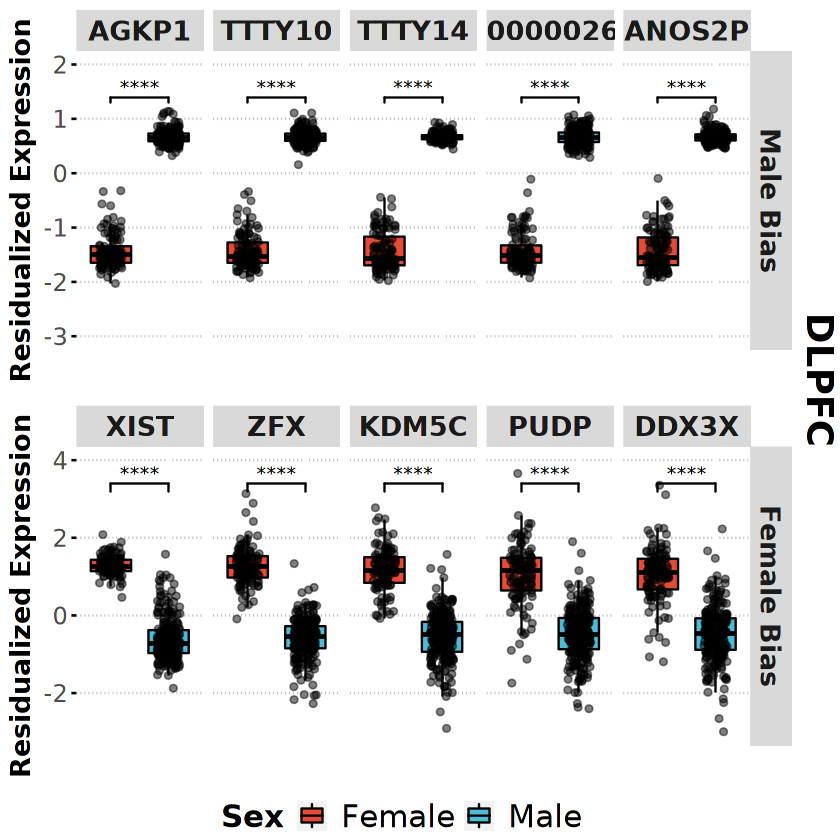

In [10]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow=2, common.legend=TRUE, legend='bottom')
figure <- annotate_figure(figure, 
                          right=text_grob("DLPFC", size=22, rot=-90, face='bold', hjust=0.8))
figure

In [11]:
save_ggplots('dlpfc_topSig_boxplot', figure, 12, 8)

## Autosomal only

### Differential expressed genes

In [12]:
genes = read.csv('../../metrics_summary/_m/autosomal_DEG.csv')
genes = genes %>% rename("gencodeID" = "Feature") %>% 
        filter(adj.P.Val < 0.05) %>%  
        select(gencodeID, ensemblID, Symbol, logFC, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(logFC > 0) %>% mutate('Direction'='Male Bias') %>% head(5) 
down_genes = genes %>% filter(logFC < 0) %>% mutate('Direction'='Female Bias') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(as.character(sig_genes$Symbol[xx]) == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

gencodeID,ensemblID,Symbol,logFC,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000205611.4,ENSG00000205611,LINC01597,1.2197981,8.648719e-19,< 2e-16,****,Male Bias,LINC01597
ENSG00000149531.15,ENSG00000149531,FRG1BP,0.6835137,9.850828e-17,< 2e-16,****,Male Bias,FRG1BP
ENSG00000283443.1,ENSG00000283443,,1.3112883,6.869947e-15,6.9e-15,****,Male Bias,ENSG00000283443
ENSG00000255346.9,ENSG00000255346,NOX5,0.9153335,2.464554e-14,2.5e-14,****,Male Bias,NOX5
ENSG00000282826.1,ENSG00000282826,FRG1CP,0.5453083,3.770177e-13,3.8e-13,****,Male Bias,FRG1CP
ENSG00000115297.10,ENSG00000115297,TLX2,-0.9522954,1.621359e-15,1.6e-15,****,Female Bias,TLX2
ENSG00000095932.6,ENSG00000095932,SMIM24,-0.6667604,1.271475e-10,1.3e-10,****,Female Bias,SMIM24
ENSG00000261600.1,ENSG00000261600,,-0.8907402,2.278248e-10,2.3e-10,****,Female Bias,ENSG00000261600
ENSG00000172460.14,ENSG00000172460,PRSS30P,-0.8169451,2.476642e-10,2.5e-10,****,Female Bias,PRSS30P


### Load residualized expression

In [13]:
resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

,ENSG00000115297.10,ENSG00000261600.1,ENSG00000255346.9,ENSG00000172460.14,ENSG00000095932.6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R10424,1.876590,-1.4648269,-0.02619369,-3.6606844,-6.8154391
R12195,-0.165569,-0.1774782,0.51385366,-0.1993152,0.1595813


### Merge dataframe

In [14]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 359  19

,rowname,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,ENSG00000115297.10
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,R10424,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,Control,1.876590
2,R12195,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,Schizo,-0.165569


### Melt data frame

In [15]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "gencodeID", values_to = "Res") %>%
    mutate_if(is.character, as.factor) %>% inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

rowname,Sex,gencodeID,Res,ensemblID,Symbol,logFC,adj.P.Val,FDR,p.signif,Direction,New_ID
<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R10424,Male,ENSG00000115297.10,1.876590,ENSG00000115297,TLX2,-0.9522954,1.621359e-15,1.6e-15,****,Female Bias,TLX2
R10424,Male,ENSG00000261600.1,-1.464827,ENSG00000261600,,-0.8907402,2.278248e-10,2.3e-10,****,Female Bias,ENSG00000261600


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


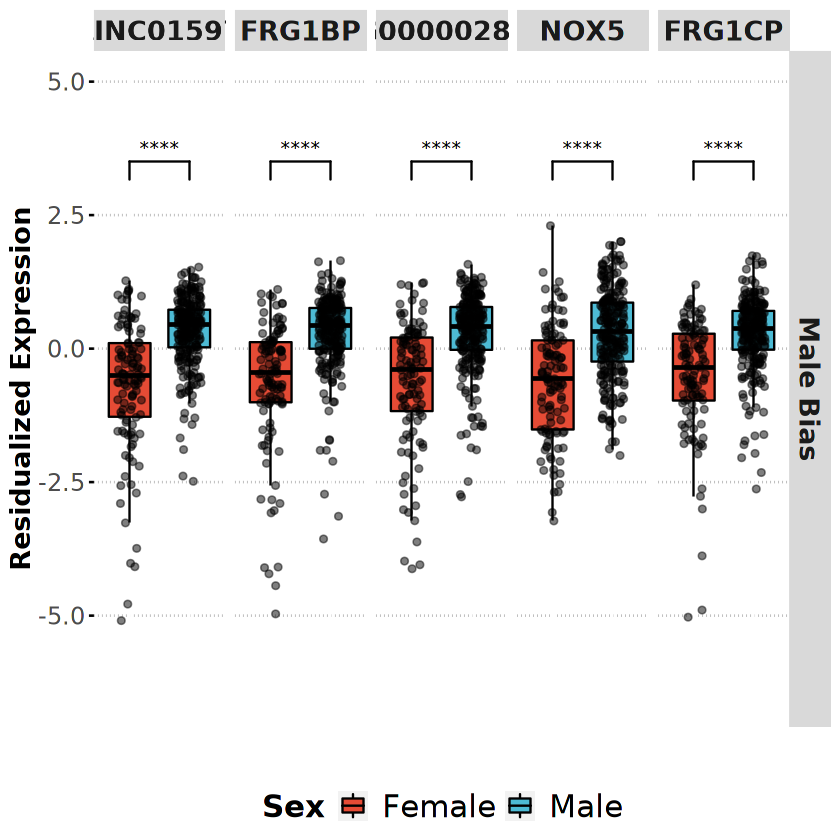

In [16]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=3.5) %>% filter(Direction == 'Male Bias') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction == "Male Bias") %>% 
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                    facet.by=c("Direction", "New_ID"), panel.labs.font=list(face='bold', size = 16),
                    ylab='Residualized Expression', add='jitter', ylim=c(-6.5, 5), 
                    add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


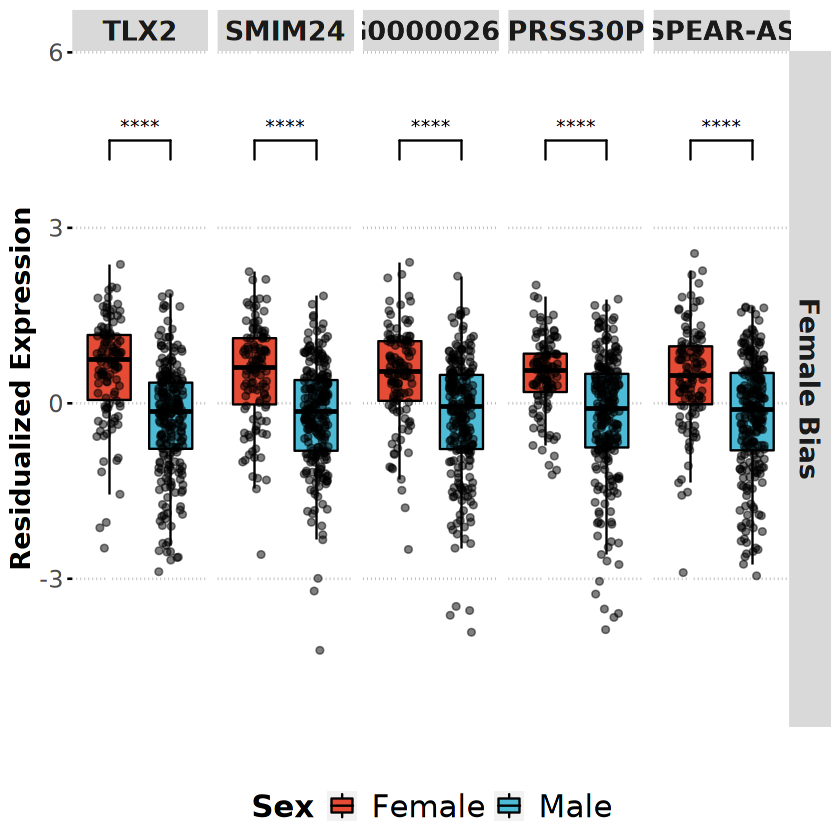

In [17]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=4.5) %>% filter(Direction == 'Female Bias') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Female Bias") %>%
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                  facet.by=c("Direction", "New_ID"), panel.labs.font=list(face='bold', size = 16),    
                  ylab='Residualized Expression', add='jitter', ylim=c(-5, 5.5),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

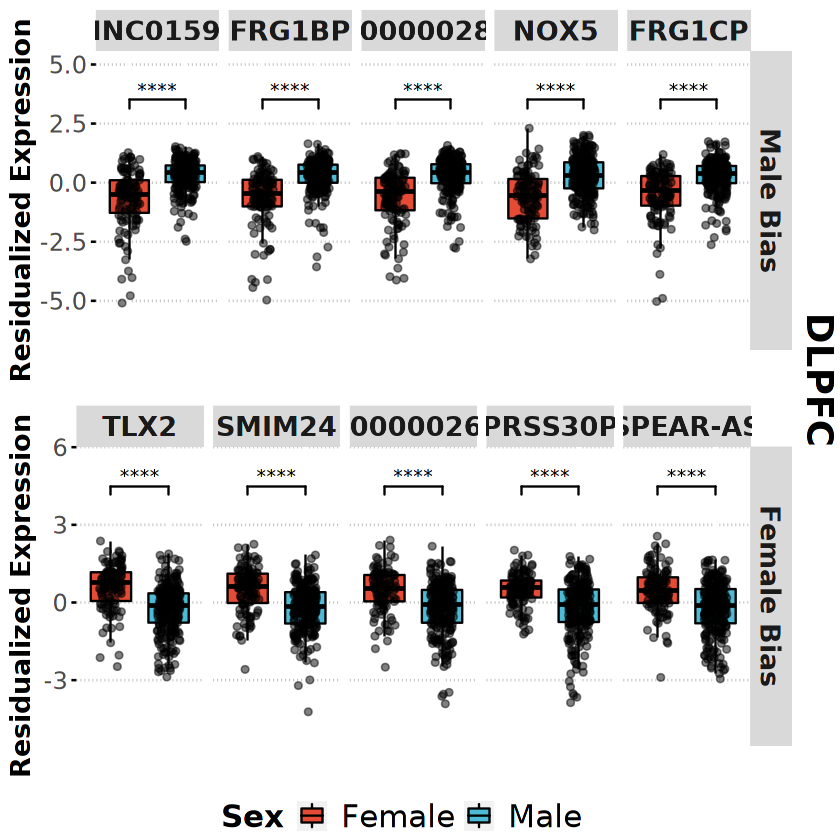

In [18]:
figure2 <- ggarrange(bxp_up, bxp_down, ncol=1, nrow=2, common.legend=TRUE, legend='bottom')
figure2 <- annotate_figure(figure2, right=text_grob("DLPFC", size=22, rot=-90, face='bold', hjust=0.8))
figure2

In [19]:
save_ggplots('dlpfc_topSig_autosomal_boxplot', figure2, 12, 8)

## Session Info

In [20]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-09 22:55:34 EDT"

   user  system elapsed 
 18.739   1.450  19.491 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-09                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 